In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Reproducibility
np.random.seed(42)

# True parameters 
true_mu = 5.0
true_sigma = 2.0

# Generate synthetic data
data = np.random.normal(loc=true_mu, scale=true_sigma, size=100)

print(f"Sample Mean     : {np.mean(data):.4f}  (true μ = {true_mu})")
print(f"Sample Std Dev  : {np.std(data):.4f}  (true σ = {true_sigma})")

Sample Mean     : 4.7923  (true μ = 5.0)
Sample Std Dev  : 1.8072  (true σ = 2.0)


In [2]:
def log_likelihood(mu, sigma, data):
    """
    Compute log-likelihood of Normal distribution.
    
    Parameters:
        mu    : mean parameter
        sigma : standard deviation (must be > 0)
        data  : observed data array
    
    Returns:
        log-likelihood value (scalar)
    """
    n = len(data)
    
    # Log-likelihood formula
    ll = -n/2 * np.log(2 * np.pi * sigma**2) \
         - (1 / (2 * sigma**2)) * np.sum((data - mu)**2)
    
    return ll


# Quick sanity check
ll_true   = log_likelihood(true_mu, true_sigma, data)
ll_sample = log_likelihood(np.mean(data), np.std(data), data)
ll_wrong  = log_likelihood(0.0, 1.0, data)  # deliberately bad guess

print(f"Log-likelihood at TRUE params   (μ=5, σ=2)        : {ll_true:.4f}")
print(f"Log-likelihood at SAMPLE params (μ=4.79, σ=1.81)  : {ll_sample:.4f}")
print(f"Log-likelihood at WRONG params  (μ=0, σ=1)        : {ll_wrong:.4f}")

Log-likelihood at TRUE params   (μ=5, σ=2)        : -202.5739
Log-likelihood at SAMPLE params (μ=4.79, σ=1.81)  : -201.0735
Log-likelihood at WRONG params  (μ=0, σ=1)        : -1403.5086


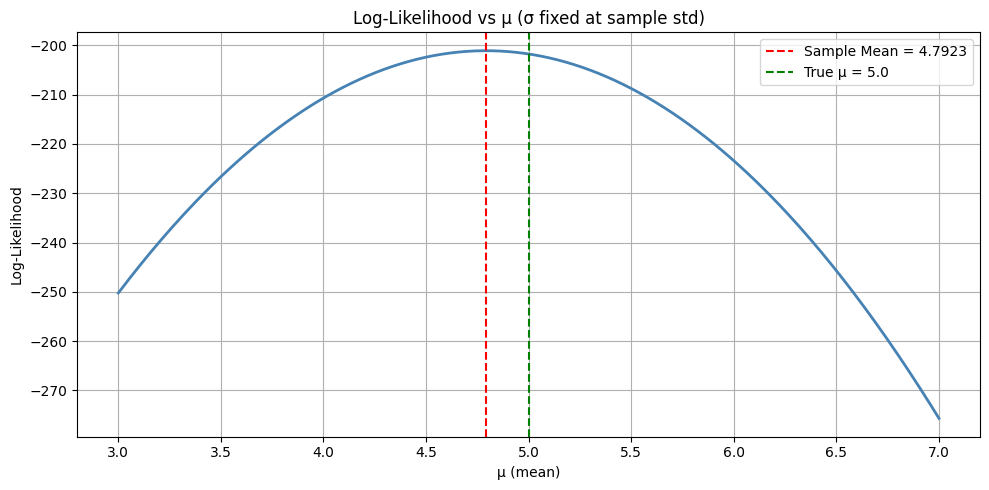

In [3]:
# Fix sigma at sample value, vary mu — to visualize 1D likelihood
mu_range = np.linspace(3, 7, 300)
ll_values = [log_likelihood(mu, np.std(data), data) for mu in mu_range]

plt.figure(figsize=(10, 5))
plt.plot(mu_range, ll_values, color='steelblue', linewidth=2)
plt.axvline(np.mean(data), color='red', linestyle='--', label=f'Sample Mean = {np.mean(data):.4f}')
plt.axvline(true_mu, color='green', linestyle='--', label=f'True μ = {true_mu}')
plt.xlabel('μ (mean)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs μ (σ fixed at sample std)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def newton_mle_mu(data, mu_init=0.0, tol=1e-6, max_iter=100):
    """
    Newton's method to find MLE of mu for Normal distribution.
    
    Parameters:
        data     : observed data
        mu_init  : starting guess for mu
        tol      : stop when update is smaller than this
        max_iter : safety limit on iterations
    
    Returns:
        mu_hat   : estimated mu
        history  : list of (iteration, mu, log-likelihood) 
    """
    n = len(data)
    sigma = np.std(data)  # fix sigma at sample std for now
    mu = mu_init
    history = []

    for i in range(max_iter):
        
        # First derivative of log-likelihood w.r.t mu
        d1 = (1/sigma**2) * np.sum(data - mu)
        
        # Second derivative
        d2 = -n / sigma**2
        
        # Newton update
        mu_new = mu - d1/d2
        
        # Record progress
        ll = log_likelihood(mu_new, sigma, data)
        history.append((i+1, mu_new, ll))
        
        # Check convergence
        if abs(mu_new - mu) < tol:
            print(f"✅ Converged in {i+1} iterations!")
            break
            
        mu = mu_new

    return mu_new, history


# Run it starting from a bad guess (far from true value)
mu_hat, history = newton_mle_mu(data, mu_init=0.0)

print(f"\nNewton's MLE estimate for μ : {mu_hat:.6f}")
print(f"Sample mean (true MLE)      : {np.mean(data):.6f}")
print(f"\nIteration history:")
print(f"{'Iter':<6} {'μ estimate':<15} {'Log-Likelihood':<15}")
print("-" * 40)
for iter, mu, ll in history:
    print(f"{iter:<6} {mu:<15.6f} {ll:<15.4f}")

✅ Converged in 2 iterations!

Newton's MLE estimate for μ : 4.792307
Sample mean (true MLE)      : 4.792307

Iteration history:
Iter   μ estimate      Log-Likelihood 
----------------------------------------
1      4.792307        -201.0735      
2      4.792307        -201.0735      


In [ ]:
def bisection_mle_mu(data, a, b, tol=1e-6, max_iter=100):
    """
    Bisection method to find MLE of mu by solving dL/dmu = 0.
    
    Parameters:
        data : observed data
        a, b : interval where derivative changes sign
        tol  : convergence tolerance
    """
    sigma = np.std(data)
    n = len(data)
    history = []

    def derivative(mu):
        # dL/dmu = (1/sigma^2) * sum(xi - mu)
        return (1/sigma**2) * np.sum(data - mu)

    # Verify sign change exists (sanity check)
    if derivative(a) * derivative(b) > 0:
        print(" No sign change in interval! Choose a wider interval.")
        return None, None

    for i in range(max_iter):
        mid = (a + b) / 2
        ll  = log_likelihood(mid, sigma, data)
        history.append((i+1, mid, ll))

        if abs(derivative(mid)) < tol or (b - a)/2 < tol:
            print(f"Converged in {i+1} iterations!")
            break

        # Narrow the interval
        if derivative(a) * derivative(mid) < 0:
            b = mid   # peak is in left half
        else:
            a = mid   # peak is in right half

    return mid, history


# Run bisection with a wide interval
mu_bisect, history_b = bisection_mle_mu(data, a=0.0, b=10.0)

print(f"\nBisection MLE estimate for μ : {mu_bisect:.6f}")
print(f"Sample mean (true MLE)       : {np.mean(data):.6f}")
print(f"\n{'Iter':<6} {'μ estimate':<15} {'Log-Likelihood':<15}")
print("-" * 40)
for iter, mu, ll in history_b:
    print(f"{iter:<6} {mu:<15.6f} {ll:<15.4f}")

✅ Converged in 24 iterations!

Bisection MLE estimate for μ : 4.792307
Sample mean (true MLE)       : 4.792307

Iter   μ estimate      Log-Likelihood 
----------------------------------------
1      5.000000        -201.7339      
2      2.500000        -281.5164      
3      3.750000        -217.7051      
4      4.375000        -203.7395      
5      4.687500        -201.2417      
6      4.843750        -201.1140      
7      4.765625        -201.0844      
8      4.804688        -201.0759      
9      4.785156        -201.0743      
10     4.794922        -201.0736      
11     4.790039        -201.0736      
12     4.792480        -201.0735      
13     4.791260        -201.0735      
14     4.791870        -201.0735      
15     4.792175        -201.0735      
16     4.792328        -201.0735      
17     4.792252        -201.0735      
18     4.792290        -201.0735      
19     4.792309        -201.0735      
20     4.792299        -201.0735      
21     4.792304        -201.

In [ ]:
def golden_section_mle_mu(data, a, b, tol=1e-6, max_iter=100):
    """
    Golden Section Search to find MLE of mu (maximization).
    
    Parameters:
        data : observed data
        a, b : search interval
        tol  : convergence tolerance
    """
    sigma = np.std(data)
    gr = (np.sqrt(5) - 1) / 2   # golden ratio ≈ 0.618
    history = []

    # Two interior points
    c = b - gr * (b - a)
    d = a + gr * (b - a)

    fc = log_likelihood(c, sigma, data)
    fd = log_likelihood(d, sigma, data)

    for i in range(max_iter):
        history.append((i+1, (a+b)/2, log_likelihood((a+b)/2, sigma, data)))

        if abs(b - a) < tol:
            print(f"Converged in {i+1} iterations!")
            break

        if fc < fd:          # maximum is in right portion
            a = c
            c = d;  fc = fd
            d = a + gr * (b - a)
            fd = log_likelihood(d, sigma, data)
        else:                # maximum is in left portion
            b = d
            d = c;  fd = fc
            c = b - gr * (b - a)
            fc = log_likelihood(c, sigma, data)

    mu_hat = (a + b) / 2
    return mu_hat, history


# Run golden section
mu_golden, history_g = golden_section_mle_mu(data, a=0.0, b=10.0)

print(f"\nGolden Section MLE estimate for μ : {mu_golden:.6f}")
print(f"Sample mean (true MLE)            : {np.mean(data):.6f}")
print(f"\n{'Iter':<6} {'μ estimate':<15} {'Log-Likelihood':<15}")
print("-" * 40)
for iter, mu, ll in history_g:
    print(f"{iter:<6} {mu:<15.6f} {ll:<15.4f}")

✅ Converged in 35 iterations!

Golden Section MLE estimate for μ : 4.792307
Sample mean (true MLE)            : 4.792307

Iter   μ estimate      Log-Likelihood 
----------------------------------------
1      5.000000        -201.7339      
2      3.090170        -245.4273      
3      4.270510        -205.2417      
4      5.000000        -201.7339      
5      4.549150        -201.9786      
6      4.827791        -201.0928      
7      4.655581        -201.3597      
8      4.762013        -201.0876      
9      4.827791        -201.0928      
10     4.787138        -201.0739      
11     4.812263        -201.0796      
12     4.796735        -201.0738      
13     4.787138        -201.0739      
14     4.793069        -201.0735      
15     4.789403        -201.0736      
16     4.791669        -201.0735      
17     4.793069        -201.0735      
18     4.792203        -201.0735      
19     4.792738        -201.0735      
20     4.792408        -201.0735      
21     4.792203   

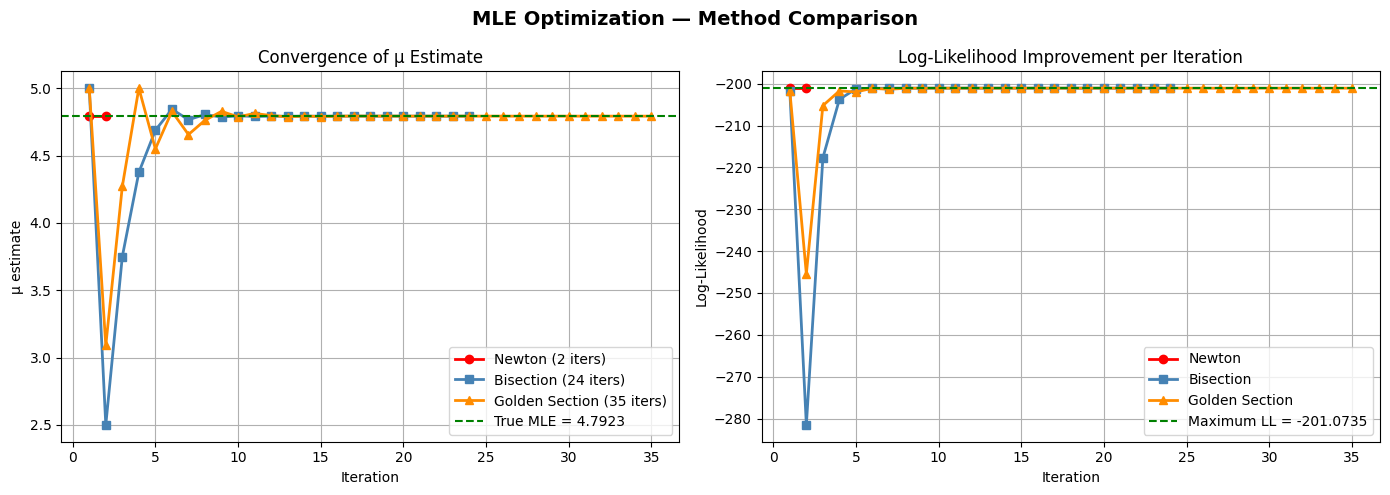

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Convergence of μ estimate over iterations ---
ax1 = axes[0]

newton_mus  = [mu for _, mu, _ in history]
bisect_mus  = [mu for _, mu, _ in history_b]
golden_mus  = [mu for _, mu, _ in history_g]

ax1.plot(range(1, len(newton_mus)+1),  newton_mus,  'o-', color='red',        label=f'Newton ({len(newton_mus)} iters)',        linewidth=2)
ax1.plot(range(1, len(bisect_mus)+1),  bisect_mus,  's-', color='steelblue',  label=f'Bisection ({len(bisect_mus)} iters)',      linewidth=2)
ax1.plot(range(1, len(golden_mus)+1),  golden_mus,  '^-', color='darkorange', label=f'Golden Section ({len(golden_mus)} iters)', linewidth=2)

ax1.axhline(np.mean(data), color='green', linestyle='--', linewidth=1.5, label=f'True MLE = {np.mean(data):.4f}')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('μ estimate')
ax1.set_title('Convergence of μ Estimate')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Log-likelihood improvement over iterations ---
ax2 = axes[1]

newton_lls = [ll for _, _, ll in history]
bisect_lls = [ll for _, _, ll in history_b]
golden_lls = [ll for _, _, ll in history_g]

ax2.plot(range(1, len(newton_lls)+1),  newton_lls,  'o-', color='red',        label=f'Newton',         linewidth=2)
ax2.plot(range(1, len(bisect_lls)+1),  bisect_lls,  's-', color='steelblue',  label=f'Bisection',      linewidth=2)
ax2.plot(range(1, len(golden_lls)+1),  golden_lls,  '^-', color='darkorange', label=f'Golden Section', linewidth=2)

ax2.axhline(-201.0735, color='green', linestyle='--', linewidth=1.5, label='Maximum LL = -201.0735')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title('Log-Likelihood Improvement per Iteration')
ax2.legend()
ax2.grid(True)

plt.suptitle('MLE Optimization — Method Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
def golden_section_mle_sigma(data, a, b, tol=1e-6, max_iter=100):
    """
    Golden Section Search to find MLE of sigma.
    sigma must be > 0, so we search over a bounded interval.
    
    Parameters:
        data : observed data
        a, b : search interval for sigma (must be positive)
    """
    mu = np.mean(data)   # fix mu at MLE estimate
    gr = (np.sqrt(5) - 1) / 2
    history = []

    c = b - gr * (b - a)
    d = a + gr * (b - a)

    fc = log_likelihood(mu, c, data)
    fd = log_likelihood(mu, d, data)

    for i in range(max_iter):
        history.append((i+1, (a+b)/2, log_likelihood(mu, (a+b)/2, data)))

        if abs(b - a) < tol:
            print(f"Converged in {i+1} iterations!")
            break

        if fc < fd:
            a = c
            c = d;  fc = fd
            d = a + gr * (b - a)
            fd = log_likelihood(mu, d, data)
        else:
            b = d
            d = c;  fd = fc
            c = b - gr * (b - a)
            fc = log_likelihood(mu, c, data)

    sigma_hat = (a + b) / 2
    return sigma_hat, history


# Run it
sigma_hat, history_s = golden_section_mle_sigma(data, a=0.01, b=10.0)

print(f"\nGolden Section MLE estimate for σ : {sigma_hat:.6f}")
print(f"Sample std (true MLE)             : {np.std(data):.6f}")

✅ Converged in 35 iterations!

Golden Section MLE estimate for σ : 1.807232
Sample std (true MLE)             : 1.807232


In [9]:
print("=" * 55)
print("   MLE OPTIMIZATION — FINAL RESULTS SUMMARY")
print("=" * 55)
print(f"\n{'Parameter':<12} {'True':<10} {'MLE Estimate':<15} {'Method'}")
print("-" * 55)
print(f"{'μ (mean)':<12} {true_mu:<10} {mu_hat:.6f}      Newton's Method")
print(f"{'σ (std)':<12} {true_sigma:<10} {sigma_hat:.6f}      Golden Section")
print(f"\n{'Method':<20} {'Iterations':<15} {'Final LL'}")
print("-" * 55)
print(f"{'Newton':<20} {len(history):<15} {history[-1][2]:.4f}")
print(f"{'Bisection':<20} {len(history_b):<15} {history_b[-1][2]:.4f}")
print(f"{'Golden Section (μ)':<20} {len(history_g):<15} {history_g[-1][2]:.4f}")
print(f"{'Golden Section (σ)':<20} {len(history_s):<15} {history_s[-1][2]:.4f}")
print("=" * 55)


   MLE OPTIMIZATION — FINAL RESULTS SUMMARY

Parameter    True       MLE Estimate    Method
-------------------------------------------------------
μ (mean)     5.0        4.792307      Newton's Method
σ (std)      2.0        1.807232      Golden Section

Method               Iterations      Final LL
-------------------------------------------------------
Newton               2               -201.0735
Bisection            24              -201.0735
Golden Section (μ)   35              -201.0735
Golden Section (σ)   35              -201.0735
